# 1. Install Dependencies and Setup

In [3]:
!pip install tensorflow opencv-python matplotlib

In [4]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      2.0.0
asttokens                    2.4.0
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.3.1
certifi                      2023.7.22
charset-normalizer           3.3.0
colorama                     0.4.6
comm                         0.1.4
contourpy                    1.1.1
cycler                       0.12.1
debugpy                      1.8.0
decorator                    5.1.1
exceptiongroup               1.1.3
executing                    2.0.0
flatbuffers                  23.5.26
fonttools                    4.43.1
gast                         0.5.4
google-auth                  2.23.3
google-auth-oauthlib         1.0.0
google-pasta                 0.2.0
grpcio                       1.59.0
h5py                         3.10.0
idna                         3.4
ipykernel                    6.25.2
ipython                      8.16.1
jed

In [5]:
import tensorflow as tf
import os

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [30]:
import cv2
import imghdr

In [31]:
data_dir = 'data' 

In [32]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [33]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
batch = data_iterator.next()

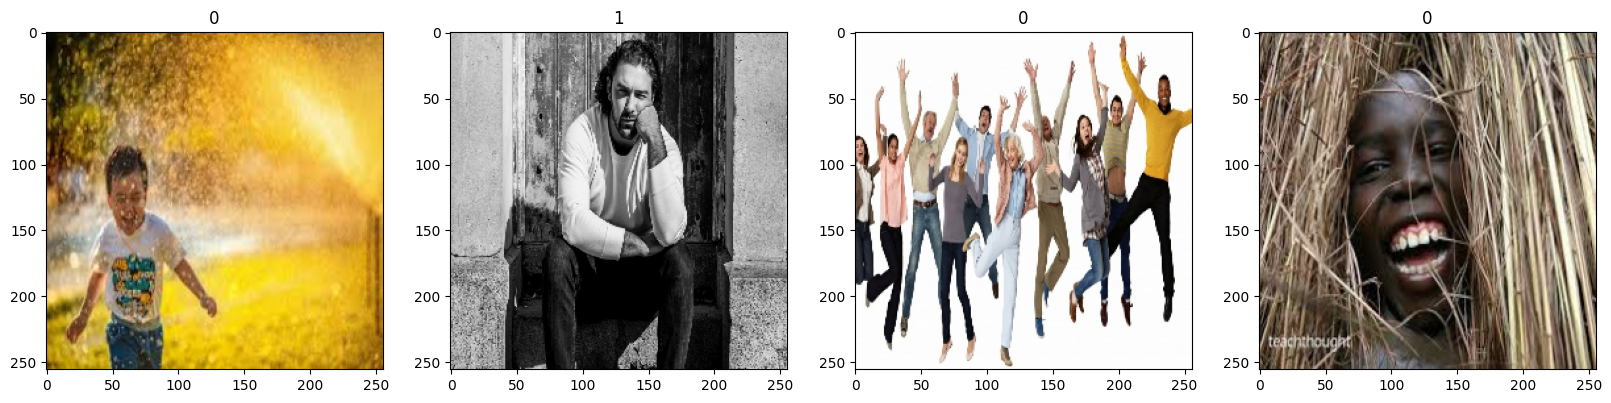

In [34]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [16]:
data = data.map(lambda x,y: (x/255, y))

In [17]:
data.as_numpy_iterator().next()

(array([[[[0.9372549 , 0.99607843, 0.9843137 ],
          [0.9372549 , 0.99607843, 0.9843137 ],
          [0.9372549 , 0.99607843, 0.9843137 ],
          ...,
          [0.35741422, 0.29411766, 0.26443014],
          [0.3666054 , 0.2912071 , 0.2627451 ],
          [0.3650429 , 0.28661153, 0.25916055]],
 
         [[0.9372549 , 0.99607843, 0.9843137 ],
          [0.9372549 , 0.99607843, 0.9843137 ],
          [0.9372549 , 0.99607843, 0.9843137 ],
          ...,
          [0.35741422, 0.29411766, 0.26443014],
          [0.3637858 , 0.2897973 , 0.2613353 ],
          [0.3647164 , 0.28644827, 0.2589973 ]],
 
         [[0.9372549 , 0.99607843, 0.9843137 ],
          [0.9372549 , 0.99607843, 0.9843137 ],
          [0.9372549 , 0.99607843, 0.9843137 ],
          ...,
          [0.35686275, 0.29356617, 0.26419318],
          [0.36064214, 0.2881544 , 0.25983456],
          [0.3633607 , 0.28577045, 0.25831944]],
 
         ...,
 
         [[0.99807274, 0.9549355 , 0.868661  ],
          [0.97266

# 5. Split Data

In [35]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [36]:
train_size

7

In [38]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [39]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [41]:
model = Sequential()

In [42]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [44]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

# 7. Train

In [46]:
logdir='logs'

In [47]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [48]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 16s 2s/step - loss: 0.8870 - accuracy: 0.5268 - val_loss: 0.6457 - val_accuracy: 0.5469
Epoch 2/20
7/7 [==============================] - 13s 2s/step - loss: 0.6547 - accuracy: 0.6161 - val_loss: 0.6358 - val_accuracy: 0.7500
Epoch 3/20
7/7 [==============================] - 13s 2s/step - loss: 0.6283 - accuracy: 0.6830 - val_loss: 0.5673 - val_accuracy: 0.7031
Epoch 4/20
7/7 [==============================] - 15s 2s/step - loss: 0.5524 - accuracy: 0.7411 - val_loss: 0.4854 - val_accuracy: 0.7812
Epoch 5/20
7/7 [==============================] - 15s 2s/step - loss: 0.4486 - accuracy: 0.8080 - val_loss: 0.5414 - val_accuracy: 0.7656
Epoch 6/20
7/7 [==============================] - 13s 2s/step - loss: 0.4343 - accuracy: 0.8170 - val_loss: 0.3504 - val_accuracy: 0.9062
Epoch 7/20
7/7 [==============================] - 13s 2s/step - loss: 0.3739 - accuracy: 0.8482 - val_loss: 0.2794 - val_accuracy: 0.8906
Epoch 8/20
7/7 [==================

# 8. Plot Performance

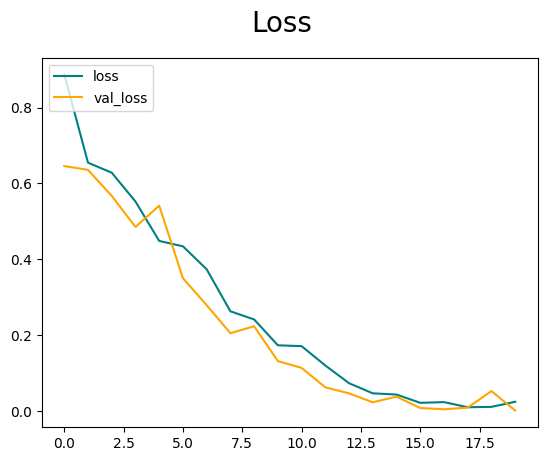

In [49]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

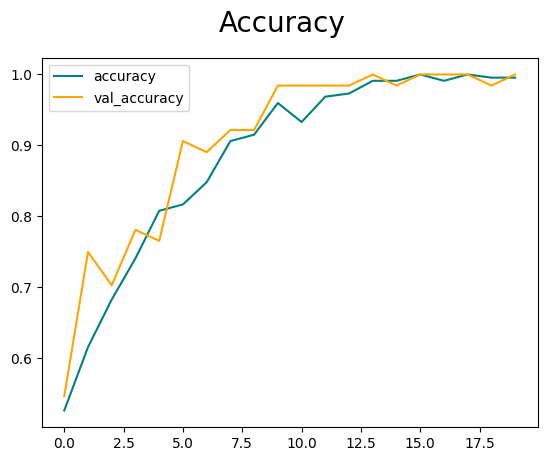

In [50]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [51]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [52]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [53]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 361ms/step


In [54]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [55]:
import cv2

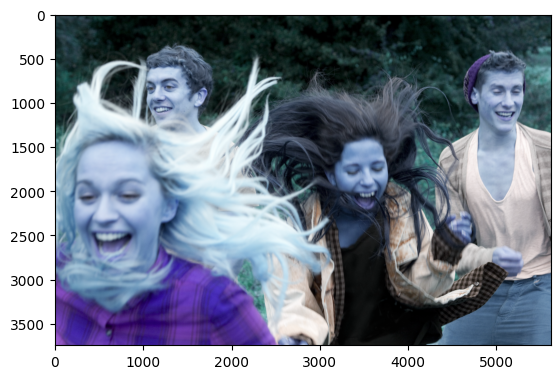

In [56]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

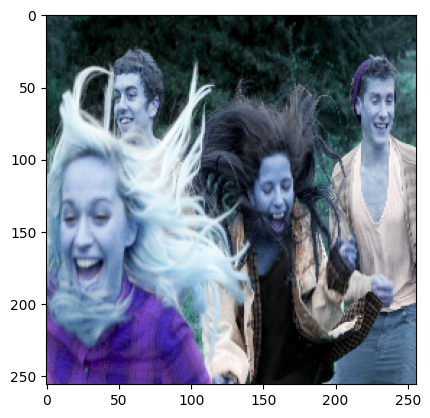

In [58]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [59]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 36ms/step


In [60]:
yhat

array([[0.76524055]], dtype=float32)

In [43]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [61]:
from tensorflow.keras.models import load_model

In [62]:
model.save(os.path.join('models','imageclassifier.h5'))

C:\Users\user\ImageClassification\imageclassification\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
new_model = load_model('imageclassifier.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)